In [61]:
# importing the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Creating the data**

In [62]:
x = np.linspace(0,50,501)   # there are 500 linearly spaced points of values ranging from 0 to 50
x[:20]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [63]:
y = np.sin(x)   # takes the sine value of x
y[:20]

array([0.        , 0.09983342, 0.19866933, 0.29552021, 0.38941834,
       0.47942554, 0.56464247, 0.64421769, 0.71735609, 0.78332691,
       0.84147098, 0.89120736, 0.93203909, 0.96355819, 0.98544973,
       0.99749499, 0.9995736 , 0.99166481, 0.97384763, 0.94630009])

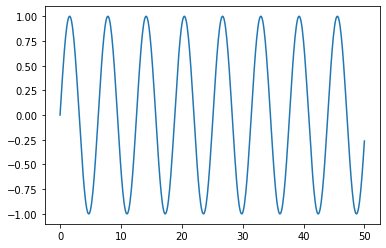

In [64]:
plt.plot(x,y)     # sine-wave from 0 to 50

In [65]:
df = pd.DataFrame(data=y, index=x, columns=['Sine'])
df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


**Splitting the data**

In [66]:
# splitting of the data into training and testing

len(df)

501

In [67]:
test_percent = 0.1  # 10% of the data to be my test_set

In [68]:
test_point = np.round(len(df)*test_percent)   # cutoff-point
test_point

50.0

In [69]:
test_ind = int(len(df) - test_point)          # cutoff-value
test_ind  

451

In [70]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [71]:
train

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
44.6,0.579164
44.7,0.657656
44.8,0.729577
44.9,0.794208


In [72]:
test.tail()

,Sine
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400
50.0,-0.262375


**Scaling the data**

In [73]:
# scale the data - since RNN are actually going to feed the output back to themselves, we need to scale the y data as well as the x data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

**Batch Generator**

In [74]:
import tensorflow as tf

In [75]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [76]:
help(TimeseriesGenerator)

Help on class TimeseriesGenerator in module keras.preprocessing.sequence:

class TimeseriesGenerator(keras.utils.data_utils.Sequence)
 |  TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)
 |  
 |  Utility class for generating batches of temporal data.
 |  
 |  Deprecated: `tf.keras.preprocessing.sequence.TimeseriesGenerator` does not
 |  operate on tensors and is not recommended for new code. Prefer using a
 |  `tf.data.Dataset` which provides a more efficient and flexible mechanism for
 |  batching, shuffling, and windowing input. See the
 |  [tf.data guide](https://www.tensorflow.org/guide/data) for more details.
 |  
 |  This class takes in a sequence of data-points gathered at
 |  equal intervals, along with time series parameters such as
 |  stride, length of history, etc., to produce batches for
 |  training/validation.
 |  
 |  Arguments:
 |      data: Indexable generator (such as li

In [77]:
# now we shall generate the batches for sequence data

length = 2    # length if the output sequences in a number of time steps
batch_size = 1   # length of the output sequences in a number of time steps

generator  = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [78]:
len(scaled_train)

451

In [79]:
len(generator)    # len(scaled_train)-length, 451-2

449

In [80]:
X,y = generator[0]

In [81]:
print(X)    # using these 2 points we are trying to predict the y value
print(y)

[[[0.49999912]
  [0.54991622]]]
[[0.59933458]]


In [82]:
scaled_train[:5]

array([[0.49999912],
       [0.54991622],
       [0.59933458],
       [0.64776041],
       [0.69470985]])

In [83]:
# now we shall try to increase the length so that many patterns and seasonal trends are covered

length = 50
batch_size = 1
generator  = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

**RNN model**

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

n_features = 1

model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.fit_generator(generator, epochs = 5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


401/401 [==============================] - 12s 28ms/step - loss: 0.0048
Epoch 2/5
401/401 [==============================] - 12s 29ms/step - loss: 8.4406e-05
Epoch 3/5
401/401 [==============================] - 12s 31ms/step - loss: 8.7138e-04
Epoch 4/5
401/401 [==============================] - 12s 30ms/step - loss: 2.9515e-04
Epoch 5/5
401/401 [==============================] - 11s 29ms/step - loss: 4.9074e-05


In [87]:
loss = pd.DataFrame(model.history.history)
loss

,loss
0,0.004801
1,0.000084
2,0.000871
3,0.000295
4,0.000049


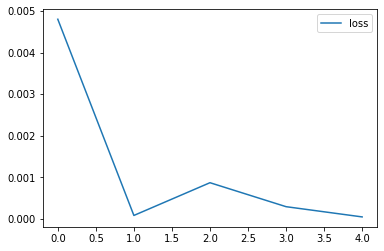

In [88]:
loss.plot()

In [89]:
# predictions
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1,length,n_features))
model.predict(first_eval_batch)       # predicting the scaled values

1/1 [==============================] - 0s 113ms/step


array([[0.93918896]], dtype=float32)

In [90]:
scaled_test[0]

# we can see that the first batch of the data is actually predicting very close values of the test set we had

array([0.94955134])

In [91]:
test_pred = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[7.98881698e-01],
        [7.57371240e-01],
        [7.13289205e-01],
        [6.67076045e-01],
        [6.19193508e-01],
        [5.70120021e-01],
        [5.20345908e-01],
        [4.70368497e-01],
        [4.20687145e-01],
        [3.71798252e-01],
        [3.24190300e-01],
        [2.78338972e-01],
        [2.34702398e-01],
        [1.93716581e-01],
        [1.55791039e-01],
        [1.21304709e-01],
        [9.06021693e-02],
        [6.39901882e-02],
        [4.17346643e-02],
        [2.40579672e-02],
        [1.11367167e-02],
        [3.10001778e-03],
        [2.81703720e-05],
        [1.95186738e-03],
        [8.85188786e-03],
        [2.06592891e-02],
        [3.72560954e-02],
        [5.84764771e-02],
        [8.41084070e-02],
        [1.13895779e-01],
        [1.47540969e-01],
        [1.84707803e-01],
        [2.25024924e-01],
        [2.68089497e-01],
        [3.13471233e-01],
        [3.60716695e-01],
        [4.09353821e-01],
        [4.58896644e-01],
        [5.0

In [92]:
# the same logic has to be applied to predict for the entire further timesteps, this was only for first batch, so we shall use for loop

test_pred = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_pred.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)    # dropping the first original point and replacing them with predicted value

1/1 [==============================] - 0s 19ms/step


In [93]:
test_pred[:5]

[array([0.93918896], dtype=float32),
 array([0.95741427], dtype=float32),
 array([0.9705099], dtype=float32),
 array([0.9766639], dtype=float32),
 array([0.975516], dtype=float32)]

In [94]:
scaled_test[:5]

array([[0.94955134],
       [0.96915662],
       [0.98407422],
       [0.99415511],
       [0.99929856]])

In [95]:
true_pred = scaler.inverse_transform(test_pred)
true_pred[:5]

array([[0.87837263],
       [0.91482297],
       [0.94101399],
       [0.95332189],
       [0.95102618]])

In [96]:
test['Predictions'] = true_pred
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Sine,Predictions
45.1,0.899097,0.878373
45.2,0.938307,0.914823
45.3,0.968142,0.941014
45.4,0.988304,0.953322
45.5,0.998591,0.951026


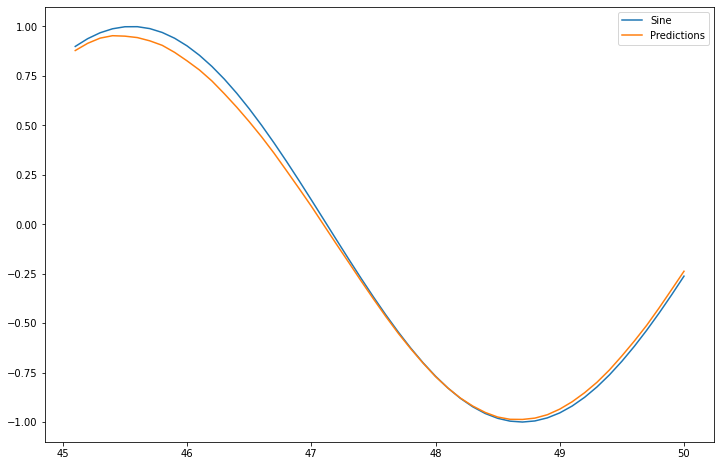

In [97]:
test.plot(figsize=(12,8))

We can see that the RNN model is actually predicting very close to the actual values

**LSTM model**

In [98]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [99]:
length = 49
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
validation_gen = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [100]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [101]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [102]:
model.fit_generator(generator, epochs=20, validation_data=validation_gen, callbacks=[early_stop])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


402/402 [==============================] - 4s 5ms/step - loss: 0.0346 - val_loss: 2.6108e-06
Epoch 2/20
402/402 [==============================] - 2s 4ms/step - loss: 2.2450e-04 - val_loss: 1.2132e-05
Epoch 3/20
402/402 [==============================] - 2s 5ms/step - loss: 1.8414e-04 - val_loss: 6.4854e-07
Epoch 4/20
402/402 [==============================] - 2s 4ms/step - loss: 9.2516e-05 - val_loss: 3.5362e-05
Epoch 5/20
402/402 [==============================] - 2s 5ms/step - loss: 2.1859e-04 - val_loss: 2.4278e-06


In [103]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 16ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


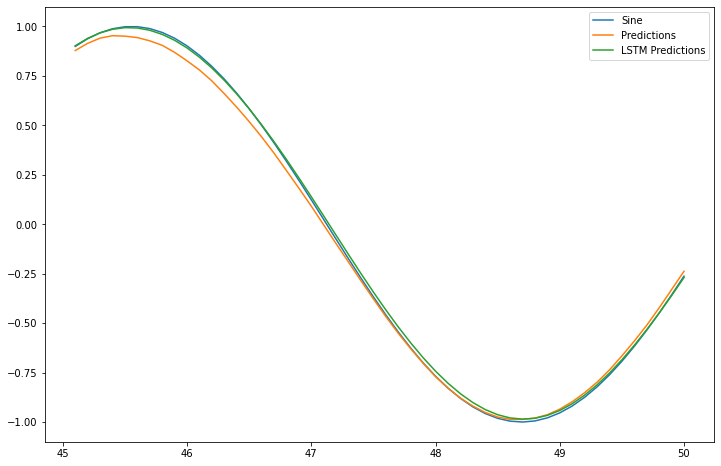

In [104]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

In [106]:
test.head()

,Sine,Predictions,LSTM Predictions
45.1,0.899097,0.878373,0.902419
45.2,0.938307,0.914823,0.939879
45.3,0.968142,0.941014,0.967771
45.4,0.988304,0.953322,0.985817
45.5,0.998591,0.951026,0.993943


# FORECASTING BEYOND

In [107]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [108]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [109]:
model = Sequential()
model.add(LSTM(50, input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [111]:
model.fit_generator(generator, epochs=8)

Epoch 1/8
 23/452 [>.............................] - ETA: 1s - loss: 2.8023e-05

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


452/452 [==============================] - 2s 5ms/step - loss: 5.9735e-05
Epoch 2/8
452/452 [==============================] - 2s 5ms/step - loss: 7.1601e-05
Epoch 3/8
452/452 [==============================] - 2s 5ms/step - loss: 6.6844e-05
Epoch 4/8
452/452 [==============================] - 2s 5ms/step - loss: 1.1763e-04
Epoch 5/8
452/452 [==============================] - 2s 4ms/step - loss: 2.3551e-05
Epoch 6/8
452/452 [==============================] - 2s 4ms/step - loss: 5.4780e-05
Epoch 7/8
452/452 [==============================] - 2s 4ms/step - loss: 4.2288e-04
Epoch 8/8
452/452 [==============================] - 2s 4ms/step - loss: 5.9733e-05


In [113]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(25):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 16ms/step


In [114]:
forecast = scaler.inverse_transform(forecast)
forecast[:5]

array([[0.89725273],
       [0.93585   ],
       [0.96511231],
       [0.98483736],
       [0.99492584]])

In [115]:
forecast_index = np.arange(50.1, 52.6, 0.1)
len(forecast_index)

25

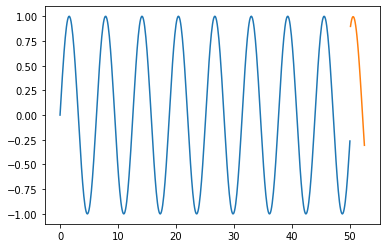

In [117]:
plt.plot(df.index, df['Sine'])
plt.plot(forecast_index, forecast)